## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

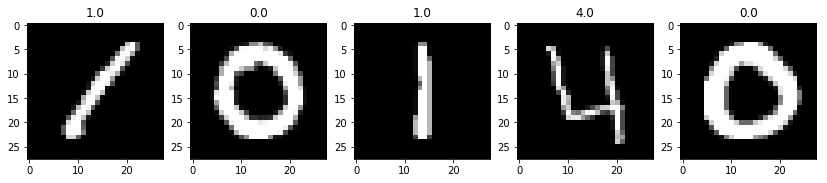

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

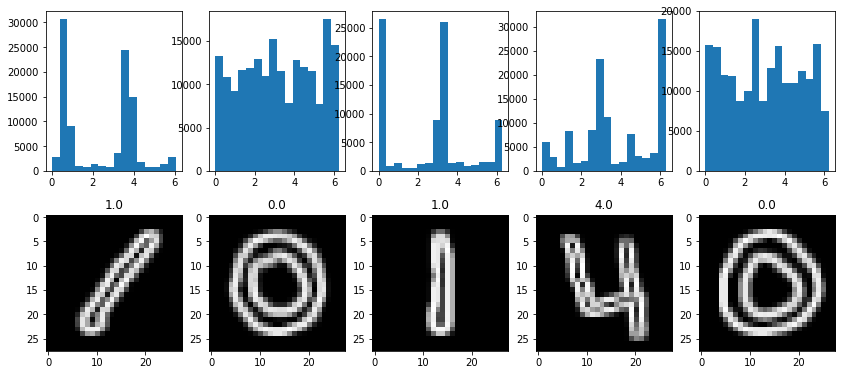

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [15]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

# 1. Baseline solution

## Вычисляем центроиды каждого из 10 классов

In [16]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [17]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [18]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [19]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.4270238095238095


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.34      0.12      0.18       816
         1.0       0.59      0.76      0.66       909
         2.0       0.33      0.29      0.31       846
         3.0       0.55      0.49      0.51       937
         4.0       0.33      0.31      0.32       839
         5.0       0.46      0.67      0.55       702
         6.0       0.24      0.45      0.31       785
         7.0       0.73      0.41      0.53       893
         8.0       0.39      0.49      0.44       835
         9.0       0.48      0.27      0.34       838

    accuracy                           0.43      8400
   macro avg       0.44      0.43      0.42      8400
weighted avg       0.45      0.43      0.42      8400



In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[102  24  82  30 106  18 221   7 179  47]
 [  0 692   2   0  44   1 139  17  13   1]
 [ 21   0 245 158  12 203  54  16 119  18]
 [ 14   0 113 456   3 235   7   2  98   9]
 [ 11 248   5   2 260   0 205  43  37  28]
 [  3   0  84  97   5 472   3   4  33   1]
 [ 53  26  66  11 116   4 355  13  76  65]
 [  4 113  38  16  66  41 189 368  15  43]
 [ 81   6  68  44  36  44 107   3 411  35]
 [ 11  73  31  20 149  11 222  30  65 226]]


## Предсказания на тестовыйх данных

In [22]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

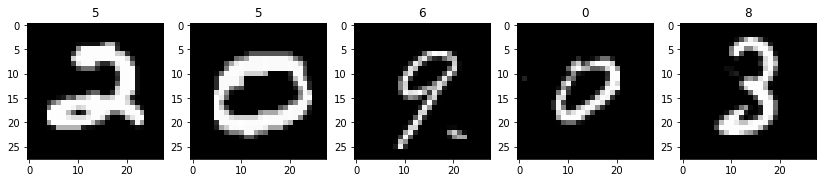

In [23]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [24]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [25]:
!head submit.txt

ImageId,Label
1,5
2,5
3,6
4,0
5,8
6,7
7,6
8,3
9,8


# 2. Linear model' solution

In [27]:
y_train.shape, y_val, x_train.shape, x_val

((33600,),
 array([8., 1., 9., ..., 3., 0., 9.]),
 (33600, 16),
 array([[0.41281347, 0.368608  , 0.18903207, ..., 0.22811746, 0.0608472 ,
         0.26683354],
        [0.65759467, 0.08075626, 0.03301447, ..., 0.01180928, 0.04207296,
         0.11769157],
        [0.3257592 , 0.50370109, 0.21290177, ..., 0.10697524, 0.09831463,
         0.06179984],
        ...,
        [0.06224049, 0.20412941, 0.25190361, ..., 0.29521826, 0.09386408,
         0.07608923],
        [0.21475273, 0.2003948 , 0.3464693 , ..., 0.08707368, 0.11888592,
         0.11854467],
        [0.28903564, 0.36368445, 0.10787793, ..., 0.10475328, 0.1526668 ,
         0.40338432]]))

In [28]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Получаем прогнозные значения модели (переменная predictions)

In [39]:
pred_val = model.predict(x_val)

## Оцениваем качество решение на валидационной выборке

In [41]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.5597619047619048


In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.37      0.25      0.29       816
         1.0       0.86      0.97      0.91       909
         2.0       0.41      0.25      0.31       846
         3.0       0.58      0.69      0.63       937
         4.0       0.59      0.50      0.54       839
         5.0       0.53      0.63      0.57       702
         6.0       0.39      0.43      0.41       785
         7.0       0.72      0.77      0.74       893
         8.0       0.44      0.53      0.48       835
         9.0       0.53      0.52      0.53       838

    accuracy                           0.56      8400
   macro avg       0.54      0.55      0.54      8400
weighted avg       0.55      0.56      0.55      8400



In [43]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[201  10  56  39  50  30 183  10 181  56]
 [  0 881   1   0  12   1   3   3   2   6]
 [ 39   0 211 189  23 170  46  51  98  19]
 [ 17   0  60 644   6 109   7  10  64  20]
 [ 19  97   5   4 418   1 127  49  25  94]
 [  6   0  65 121   0 440   9  16  41   4]
 [107  11  49  19  73  13 339  15  87  72]
 [  9  21  24   8  23  14  39 688  15  52]
 [108   0  26  58  18  51  52  19 441  62]
 [ 42   9  12  30  89   8  59  95  55 439]]


## Предсказания на тестовыйх данных

In [46]:
pred_test = model.predict(test_hist)

## Визуализируем предсказания

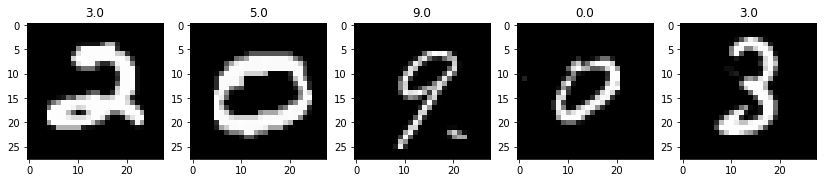

In [47]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

# 3. RF' solution

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [69]:
pred_val = clf_rf.predict(x_val)

## Оцениваем качество решение на валидационной выборке

In [70]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.6466666666666666


In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.43      0.41      0.42       816
         1.0       0.98      0.96      0.97       909
         2.0       0.49      0.47      0.48       846
         3.0       0.65      0.68      0.66       937
         4.0       0.73      0.70      0.71       839
         5.0       0.64      0.66      0.65       702
         6.0       0.48      0.48      0.48       785
         7.0       0.87      0.79      0.83       893
         8.0       0.51      0.57      0.54       835
         9.0       0.66      0.69      0.67       838

    accuracy                           0.65      8400
   macro avg       0.64      0.64      0.64      8400
weighted avg       0.65      0.65      0.65      8400



In [72]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[331   6  62  32  29  17 128  12 162  37]
 [  2 872   2   0  20   0   1   6   0   6]
 [ 63   0 401 124   3  88  62  13  75  17]
 [ 22   0  98 636   0  86  10   4  74   7]
 [ 15  11  15   3 589   1  82  27   7  89]
 [  7   0  82 105   1 464   7   4  29   3]
 [136   1  55  12  54   9 377  11  72  58]
 [  6   3  35   4  47  12  22 706   5  53]
 [143   0  40  50   9  43  39   4 479  28]
 [ 45   1  24  15  58   3  61  24  30 577]]


## Предсказания на тестовыйх данных

In [73]:
pred_test = model.predict(test_hist)

## Визуализируем предсказания

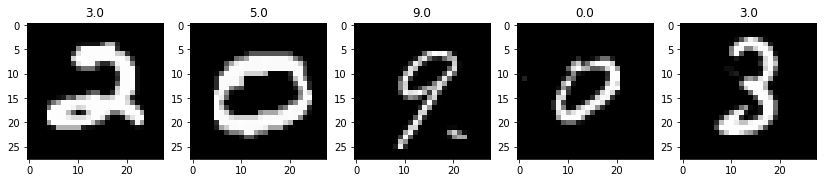

In [74]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

# 3. CATBOOST' solution

In [78]:
from catboost import CatBoostClassifier

In [84]:
model = CatBoostClassifier()
model.fit(x_train, y_train)

0:	learn: 2.2481560	total: 323ms	remaining: 5m 22s
1:	learn: 2.2002782	total: 661ms	remaining: 5m 30s
2:	learn: 2.1605678	total: 987ms	remaining: 5m 28s
3:	learn: 2.1247526	total: 1.34s	remaining: 5m 32s
4:	learn: 2.0901051	total: 1.68s	remaining: 5m 33s
5:	learn: 2.0561477	total: 2s	remaining: 5m 31s
6:	learn: 2.0269351	total: 2.34s	remaining: 5m 32s
7:	learn: 1.9992119	total: 2.68s	remaining: 5m 32s
8:	learn: 1.9726455	total: 3s	remaining: 5m 29s
9:	learn: 1.9485146	total: 3.31s	remaining: 5m 28s
10:	learn: 1.9264300	total: 3.64s	remaining: 5m 27s
11:	learn: 1.9034087	total: 3.96s	remaining: 5m 26s
12:	learn: 1.8834582	total: 4.29s	remaining: 5m 25s
13:	learn: 1.8636927	total: 4.65s	remaining: 5m 27s
14:	learn: 1.8434114	total: 4.98s	remaining: 5m 26s
15:	learn: 1.8249368	total: 5.3s	remaining: 5m 25s
16:	learn: 1.8069513	total: 5.64s	remaining: 5m 25s
17:	learn: 1.7879049	total: 5.99s	remaining: 5m 26s
18:	learn: 1.7699113	total: 6.33s	remaining: 5m 26s
19:	learn: 1.7522342	total: 6

In [85]:
pred_val = model.predict(x_val)

## Оцениваем качество решение на валидационной выборке

In [86]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.6630952380952381


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

## Предсказания на тестовыйх данных

In [58]:
pred_test = model.predict(test_hist)

## Визуализируем предсказания

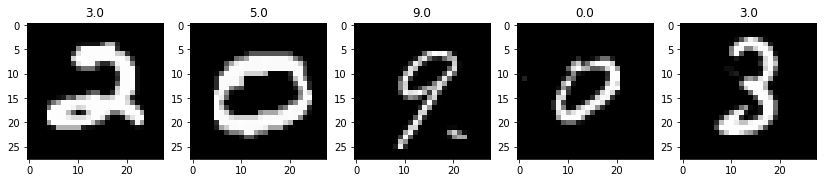

In [59]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [90]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [91]:
!head submit.txt

ImageId,Label
1,3
2,5
3,9
4,0
5,3
6,7
7,0
8,3
9,9
